In [10]:
import json
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
%matplotlib inline

In [2]:
class Scoreboard:
    def __init__(self, teams, challenges, solves):
        self.teams = teams
        self.challenges = challenges
        self.solves = solves
    def calculate_team_score_at_time(self, team_id, timestamp):
        solves_in_timerange = self.solves.before(timestamp)
        solved_challenge_ids = solves_in_timerange.for_team(team_id).df.challenge_id.values
        total_score = 0
        for cid in solved_challenge_ids:
            timebounded_challenge_solves = solves_in_timerange.for_challenge(cid)
            total_score += self.challenges[cid].point_value(timebounded_challenge_solves, team_id)
        return total_score
    def calculate_team_score_as_time_series(self, team_id):
        idx = self.solves.for_team(team_id).df.index
        return pd.Series([s.calculate_team_score_at_time(team_id, idx) for idx in idx], index=idx, name=self.teams[team_id].name)
    def __repr__(self):
        return f"[Scoreboard with {len(teams)} teams, {len(challenges)} challenges, and {len(solves.df.index)} solves]"
    
class Solves:
    def __init__(self, df):
        self.df = df
    def from_json(solves_r):
        solve_idx = pd.DatetimeIndex(map(lambda x: x['created_at'], solves_r))
        solve_cols = ['solve_id', 'team_id', 'challenge_id']
        solve_data = map(lambda x: [x['id'], x['team_id'], x['challenge_id']], solves_r)
        solves = pd.DataFrame(solve_data, index=solve_idx, columns=solve_cols)
        return Solves(solves)
    def for_team(self, team_id):
        return Solves(self.df[self.df['team_id']==team_id])
    def for_challenge(self, challenge_id):
        return Solves(self.df[self.df['challenge_id']==challenge_id])
    def before(self, max_time):
        return Solves(self.df[:max_time])
    def __repr__(self):
        return f"[Solves df={self.df}]"

class Challenge:
    def __init__(self, challenge_id, name, score_strategy):
        self.challenge_id = challenge_id
        self.name = name
        self.score_strategy = score_strategy
    def point_value(self, solves, team_id):
        return self.score_strategy.point_value(solves, team_id)
    def __repr__(self):
        return f"[Challenge challenge_id={self.challenge_id} name={self.name} score_strategy={self.score_strategy}]"
        
class Team:
    def __init__(self, team_id, name, solved_challenges=[]):
        self.team_id = team_id
        self.name = name
        self.solved_challenges = solved_challenges
    def from_json(team_json):
        return Team(team_json['id'], team_json['name'])
    def add_solve(self, time, challenge_id):
        self.solved_challenges.add(challenge_id)
    def __str__(self):
        return f"[team_id={self.team_id}, name={self.name}, solves={self.solved_challenges}]"
    def __repr__(self):
        return self.__str__()

In [3]:
class SimplePointValueStrategy:
    def __init__(self, start_points, breakthrough_point_values=[]):
        self.start_points = start_points
        self.breakthrough_point_values = breakthrough_point_values
    def point_value(self, solves, team_id=None):
        self._validate(solves)
        base_points = self.base_point_value(solves)
        point_offset = self.breakthrough_point_value(solves, team_id)
        return base_points + point_offset
    def _validate(self, solves):
        # Need to make sure all of the supplied solves are for the same challenge
        cids = solves.df.challenge_id.unique()
        if cids.size != 1:
            raise BaseException(f'Expected exactly one challenge_id in solve data, but got {cids}')
    def breakthrough_point_value(self, solves, team_id=None):
        if team_id == None or not self.breakthrough_point_values:
            return 0
        breakthrough_solves = solves[:len(self.breakthrough_point_values)]
        solve_indices = breakthrough_solves.query(f'team_id == {team_id}').index
        if solve_indices.shape[0] == 0:
            # No results returned
            return 0
        solve_index = solve_indices[0]
        solve_row_number = breakthrough_solves.index.get_loc(solve_index)
        return self.breakthrough_point_values[solve_row_number]

    # Overrideable methods below
    def base_point_value(self, solves):
        return self.start_points
    def __repr__(self):
        rep = f'[SimplePointValueStrategy start_points={self.start_points}'
        if self.breakthrough_point_values:
            return rep + f' breakthrough_points={self.breakthrough_point_values}]'
        return rep

class SimplePointValueChallengeLoader:
    def from_json(challenge_json):
        strategy = SimplePointValueStrategy(challenge_json['points'])
        return Challenge(challenge_id=challenge_json['id'],
                        name=challenge_json['name'],
                        score_strategy=strategy)
        

In [31]:
challenges_r = json.load(open('./data/legitbs/2017-quals/challenges.json', 'r'))
solves_r = json.load(open('./data/legitbs/2017-quals/solutions.json', 'r'))
teams_r  = json.load(open('./data/legitbs/2017-quals/teams.json', 'rb'))

In [ ]:
challenges = {x.challenge_id:x for x in map(SimplePointValueChallengeLoader.from_json, challenges_r)}
teams = {x.team_id:x for x in map(Team.from_json, teams_r)}
solves = Solves.from_json(solves_r)
s = Scoreboard(teams, challenges, solves)

In [68]:
# Manually-entered top 15 from https://legitbs.net/statdump_2017/scoreboard.html
top_15 = ['PPP', 'Tea Deliverers', 'Shellphish', 'DEFKOR', "A*0*E",
          'hacking4danbi', '!SpamAndHex', 'RRR', 'Team Rocket ☠️', 'Lab RATs',
          'koreanbadass', 'Samurai', 'Eat Sleep Pwn Repeat', '9447', 'TokyoWesterns with AST']
teams_by_name = {teams[t].name:t for t in teams}
team_ids = [teams_by_name[x] for x in top_15]
series = map(s.calculate_team_score_as_time_series, team_ids)
ts = pd.concat(series, axis=1)

C:\Users\wilson\Anaconda3\lib\site-packages\pandas\core\indexing.py:376: FutureWarning: Converting timezone-aware DatetimeArray to timezone-naive ndarray with 'datetime64[ns]' dtype. In the future, this will return an ndarray with 'object' dtype where each element is a 'pandas.Timestamp' with the correct 'tz'.
	To accept the future behavior, pass 'dtype=object'.
	To keep the old behavior, pass 'dtype="datetime64[ns]"'.
  self.obj[key] = _infer_fill_value(value)
C:\Users\wilson\Anaconda3\lib\site-packages\seaborn\relational.py:792: FutureWarning: Converting timezone-aware DatetimeArray to timezone-naive ndarray with 'datetime64[ns]' dtype. In the future, this will return an ndarray with 'object' dtype where each element is a 'pandas.Timestamp' with the correct 'tz'.
	To accept the future behavior, pass 'dtype=object'.
	To keep the old behavior, pass 'dtype="datetime64[ns]"'.
  x, y = np.asarray(x), np.asarray(y)


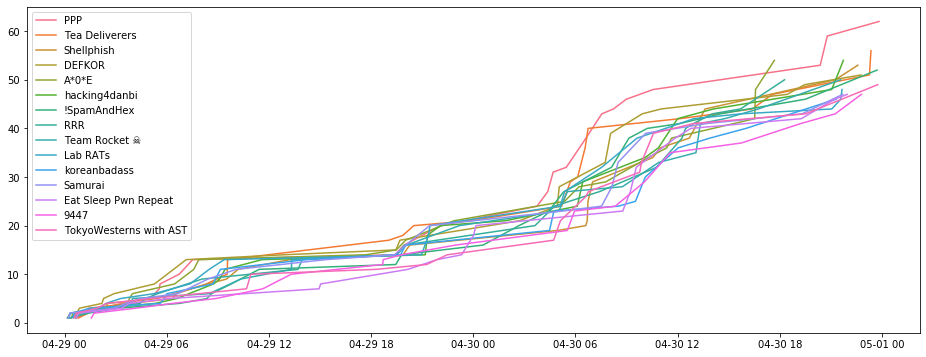

In [69]:
plt.figure(figsize=(16, 6))
sns.lineplot(data=ts, dashes=False)

In [70]:
ts.apply(lambda x: x[x.last_valid_index()])

PPP                       62.0
Tea Deliverers            56.0
Shellphish                53.0
DEFKOR                    51.0
A*0*E                     54.0
hacking4danbi             54.0
!SpamAndHex               52.0
RRR                       50.0
Team Rocket ☠️            50.0
Lab RATs                  48.0
koreanbadass              46.0
Samurai                   47.0
Eat Sleep Pwn Repeat      47.0
9447                      47.0
TokyoWesterns with AST    49.0
dtype: float64